# Machine Learning Exercise 14

# CNN Ensembles - CIFAR10 



##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.9.2
Found GPU at: /device:GPU:0


## Load data

Load training data from Keras library




In [ ]:
def load_cifar10():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = tf.keras.datasets.cifar10.load_data()
    print(Ytrain.shape)
    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3])
    ntest = Xtest.shape[0]
    num_classes = np.max(np.unique(Ytrain)) + 1
    print("Training input %s" %str(Xtrain.shape))
    print("Training output %s" %str(Ytrain.shape))
    print("Test input %s" %str(Xtest.shape))
    print("Test output %s" %str(Ytest.shape))
    print("Input shape: %s" %str(input_shape))
    print("Number of classes: %d" %num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    
    # Transform output to one-out-of-n encoding
    Ytrain = tf.keras.utils.to_categorical(Ytrain, num_classes)
    Ytest = tf.keras.utils.to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_cifar10()

(50000, 1)
Training input (50000, 32, 32, 3)
Training output (50000, 1)
Test input (10000, 32, 32, 3)
Test output (10000, 1)
Input shape: (32, 32, 3)
Number of classes: 10


## Show random image



9


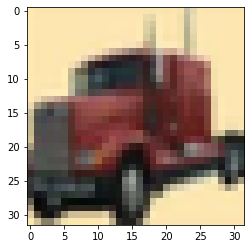

In [ ]:
i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')

label = Ytrain[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(image, cmap='gray')
plt.show()


##CNN ensemble model


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

# single model
def CNN(input_shape, num_classes, base_width=16, depth=4):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width
    kernel_size = 3
    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
        x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=16, depth=4):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model


# create the ensemble model
ens_dim = 3
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_24 (Functional)          (None, 10)           102570      ['input_33[0][0]']               
                                                                                                  
 model_25 (Functional)          (None, 10)           102570      ['input_33[0][0]']               
                                                                                                  
 model_26 (Functional)          (None, 10)           102570      ['input_33[0][0]']               
                                                                                     

# Train setup

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test_accuracy(model, history):
    # accuracy
    ind_test_acc = []
    for key in history.history.keys():
      if ("val" in key) and ("accuracy" in key):
        ind_test_acc.append(history.history[key][-1])
    print("Single models test accuracy: ", ind_test_acc)

    # ensemble test accuracy
    preds = np.array(model.predict(Xtest))
    # average over the ensemble
    preds_ens = np.mean(preds, axis=0)
    ens_test_acc = accuracy_score(np.argmax(Ytest, axis=-1), np.argmax(preds_ens, axis=-1))
    print("Ensemble test accuracy: ", ens_test_acc)

    return ind_test_acc, ens_test_acc


history = tf.keras.callbacks.History()
ind_test_accuracy = []
ens_test_accuracy = []

## Train

In [ ]:
epochs = 5
for _ in range(epochs):
    model.fit(Xtrain, [Ytrain for _ in range(ens_dim)], batch_size=32, epochs=1, callbacks=[history], validation_data = (Xtest,[Ytest for _ in range(ens_dim)]))

    iacc, eacc = test_accuracy(model, history)
    ind_test_accuracy.append(iacc)
    ens_test_accuracy.append(eacc)


1563/1563 [==============================] - 14s 9ms/step - loss: 1.5938 - model_24_loss: 0.5191 - model_25_loss: 0.5266 - model_26_loss: 0.5481 - model_24_accuracy: 0.8162 - model_25_accuracy: 0.8126 - model_26_accuracy: 0.8035 - val_loss: 2.4294 - val_model_24_loss: 0.7963 - val_model_25_loss: 0.8028 - val_model_26_loss: 0.8304 - val_model_24_accuracy: 0.7435 - val_model_25_accuracy: 0.7379 - val_model_26_accuracy: 0.7369
Single models test accuracy:  [0.7434999942779541, 0.7379000186920166, 0.7368999719619751]
313/313 [==============================] - 1s 3ms/step
Ensemble test accuracy:  0.7839
1563/1563 [==============================] - 15s 9ms/step - loss: 1.5495 - model_24_loss: 0.5014 - model_25_loss: 0.5116 - model_26_loss: 0.5365 - model_24_accuracy: 0.8213 - model_25_accuracy: 0.8163 - model_26_accuracy: 0.8081 - val_loss: 2.4070 - val_model_24_loss: 0.7977 - val_model_25_loss: 0.8257 - val_model_26_loss: 0.7836 - val_model_24_accuracy: 0.7406 - val_model_25_accuracy: 0.738

##Evaluate the model

## Compare single networks with ensemble


In [ ]:
print(ind_test_accuracy)
print(ens_test_accuracy)


[[0.5638999938964844, 0.5475999712944031, 0.5724999904632568], [0.6467000246047974, 0.5845000147819519, 0.6294000148773193], [0.6736999750137329, 0.6585999727249146, 0.652899980545044], [0.6985999941825867, 0.6761999726295471, 0.6815000176429749], [0.7135999798774719, 0.7053999900817871, 0.6933000087738037], [0.7088000178337097, 0.7109000086784363, 0.7028999924659729], [0.7253999710083008, 0.7206000089645386, 0.7171000242233276], [0.7437000274658203, 0.7168999910354614, 0.7271000146865845], [0.7422000169754028, 0.7282000184059143, 0.7225000262260437], [0.7440999746322632, 0.7360000014305115, 0.7322999835014343], [0.7513999938964844, 0.7386999726295471, 0.7400000095367432], [0.756600022315979, 0.7423999905586243, 0.7354999780654907], [0.754800021648407, 0.7394999861717224, 0.7373999953269958], [0.7387999892234802, 0.7379000186920166, 0.7307000160217285], [0.7584999799728394, 0.7404000163078308, 0.734499990940094], [0.7434999942779541, 0.7379000186920166, 0.7368999719619751], [0.74059998

Text(0.5, 0, 'epoch')

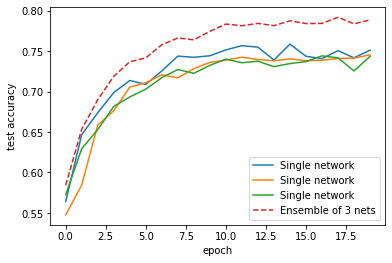

In [ ]:
plt.plot(ind_test_accuracy, label="Single network")
plt.plot(ens_test_accuracy, linestyle="--", label="Ensemble of {} nets".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')

# Home Exercises

**Question 1** 

Evaluate the performance of ensembles varying the number of base members.